<a href="https://colab.research.google.com/github/vermanaman419-prog/Bank_Customers_Churn_Prediction/blob/main/bank_customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Customer Churn Prediction Using Machine Learning

**1**. **Imports** & **load** **data**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost as xgb

# load dataset (assumes churn.csv is in working directory / content)
df = pd.read_csv('churn.csv')
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**2. Quick data overview**

In [ ]:
print("Shape:", df.shape)
display(df.info())
display(df.describe(include='all').T)

# show target distribution
print("\nTarget distribution (Exited):")
print(df['Exited'].value_counts())
print(df['Exited'].value_counts(normalize=True).map("{:.2%}".format))


Shape: (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0



Target distribution (Exited):
Exited
0    7963
1    2037
Name: count, dtype: int64
Exited
0    79.63%
1    20.37%
Name: proportion, dtype: object


3. Clean / simple preprocessing preview

In [ ]:
# drop ID columns if present
drop_cols = [c for c in ['RowNumber','CustomerId','Surname'] if c in df.columns]
df_clean = df.drop(columns=drop_cols)
df_clean = df_clean.copy()

# check for missing values
print("Missing values per column:")
print(df_clean.isnull().sum())

# if any numeric columns are strings, attempt convert:
for col in df_clean.select_dtypes(include='object').columns:
    if col not in ['Geography','Gender']:  # keep real categorical
        # try convert to numeric and coerce
        df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')

df_clean.head()


Missing values per column:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**4. EDA: basic plots (6 visuals)**

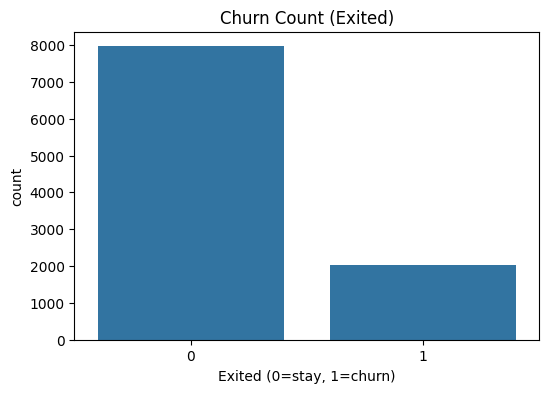

In [ ]:
# A. Churn count
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df_clean)
plt.title('Churn Count (Exited)')
plt.xlabel('Exited (0=stay, 1=churn)')
plt.show()


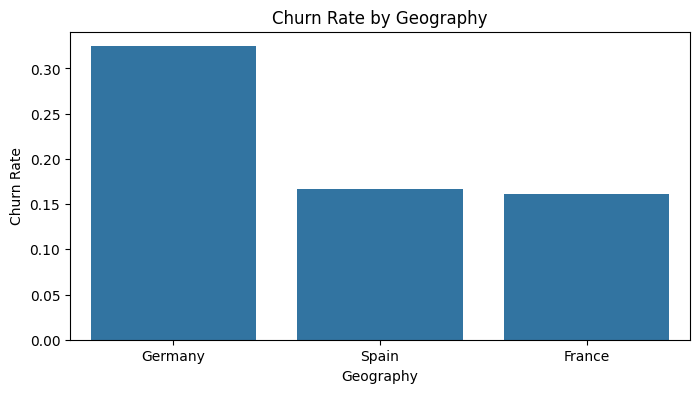

In [ ]:
# B. Churn rate by Geography
plt.figure(figsize=(8,4))
churn_by_geo = df_clean.groupby('Geography')['Exited'].mean().sort_values(ascending=False)
sns.barplot(x=churn_by_geo.index, y=churn_by_geo.values)
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Geography')
plt.show()


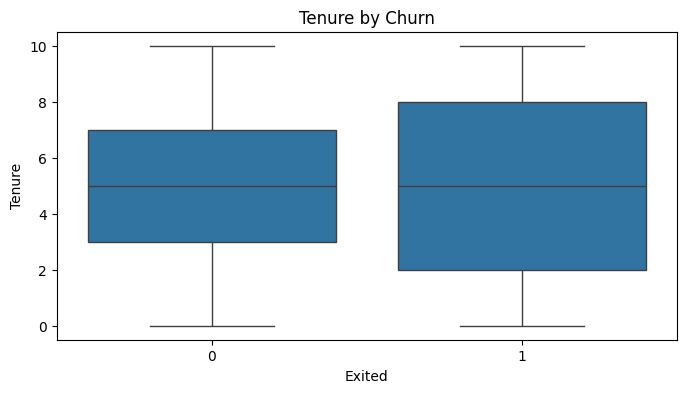

In [ ]:
# C. Churn vs Tenure (boxplot)
plt.figure(figsize=(8,4))
sns.boxplot(x='Exited', y='Tenure', data=df_clean)
plt.title('Tenure by Churn')
plt.show()

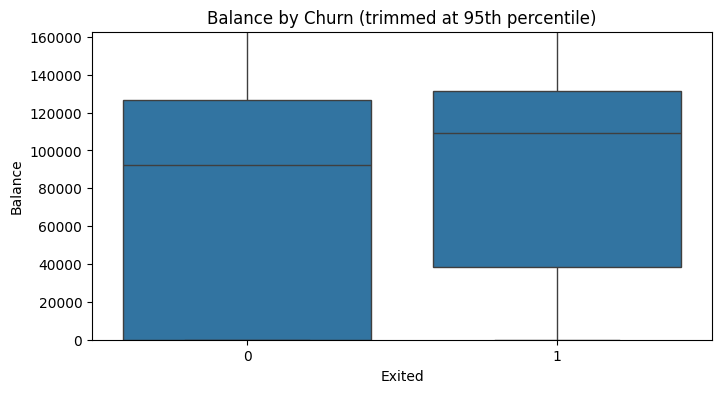

In [ ]:
# D. Balance distribution by Churn (boxplot)
plt.figure(figsize=(8,4))
sns.boxplot(x='Exited', y='Balance', data=df_clean)
plt.ylim(0, df_clean['Balance'].quantile(0.95))  # limit outliers for view
plt.title('Balance by Churn (trimmed at 95th percentile)')
plt.show()

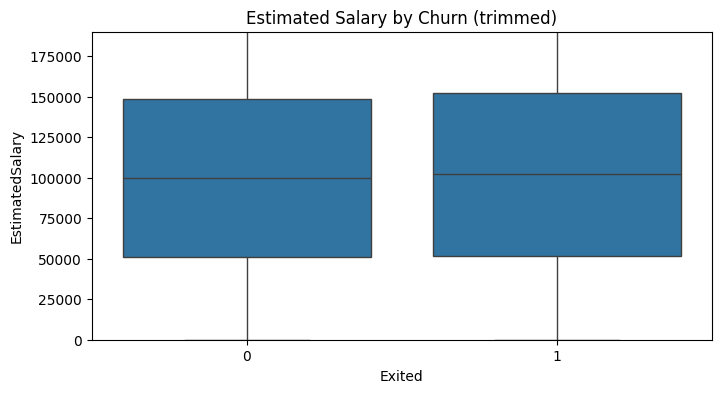

In [ ]:
# E. Monthly / EstimatedSalary (here EstimatedSalary) by Churn
plt.figure(figsize=(8,4))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df_clean)
plt.ylim(0, df_clean['EstimatedSalary'].quantile(0.95))
plt.title('Estimated Salary by Churn (trimmed)')
plt.show()

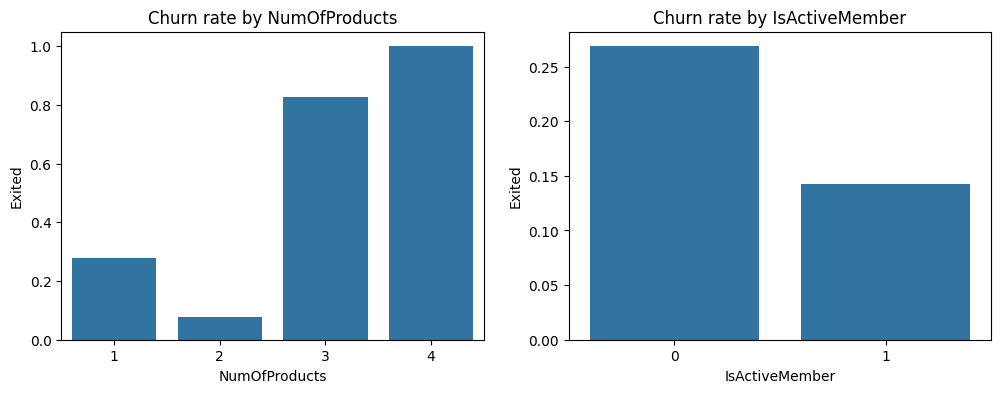

In [ ]:
# F. Contract-like proxies: NumOfProducts / IsActiveMember vs Exited
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='NumOfProducts', y='Exited', data=df_clean, ci=None)
plt.title('Churn rate by NumOfProducts')
plt.subplot(1,2,2)
sns.barplot(x='IsActiveMember', y='Exited', data=df_clean, ci=None)
plt.title('Churn rate by IsActiveMember')
plt.show()

**5**. **Preprocessing** + **Train**/**Test** **split** (**pipeline**)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib


In [ ]:
features = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember'
]

X = df[features]
y = df['Exited']   # target column


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])


In [ ]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.807

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      1593
           1       0.62      0.14      0.22       407

    accuracy                           0.81      2000
   macro avg       0.72      0.56      0.56      2000
weighted avg       0.78      0.81      0.75      2000


Confusion Matrix:
 [[1558   35]
 [ 351   56]]


In [ ]:
joblib.dump(pipeline, "churn_model.joblib")
print("Model saved as churn_model.joblib")


Model saved as churn_model.joblib


In [ ]:
print ("numpy",np.__version__)
print ("pandas",pd.__version__)
print ("sklearn",sklearn.__version__)
print ("Flask",flask.__version__)
print ("joblib",joblib.__version__)
print ("gunicorn",gunicorn.__version__)
print ("xgboost",xgb.__version__)

numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
Flask 3.1.2
joblib 1.5.2
gunicorn 23.0.0
xgboost 3.1.2
